In [113]:
from dotenv import load_dotenv
load_dotenv()
import os
import MySQLdb
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers

mysql = MySQLdb.connect(
  host= os.getenv("HOST"),
  user=os.getenv("USERNAME"),
  passwd= os.getenv("PASSWORD"),
  db= os.getenv("DATABASE"),
  ssl_mode = "VERIFY_IDENTITY",
  ssl      = {
    "ca": os.environ.get('MYSQL_ATTR_SSL_CA')
  }
)

db = mysql.cursor()

In [139]:
db.execute("""
  SELECT b.eColi,  w.precipitation, w.meanTemp, w.speedOfMaxGust
  FROM BeachReading b
  INNER JOIN Weather w
  ON DATE_FORMAT(w.date,  "%Y-%m-%d") = DATE_SUB(DATE_FORMAT(b.date,  "%Y-%m-%d"), INTERVAL 1 DAY)
  WHERE b.beachId = 2
  AND DATE_FORMAT(w.date,  "%Y-%m-%d") > '2020-12-31'
  
""")


myresult = db.fetchall()

In [142]:

df = pd.DataFrame(myresult)

df.columns = ['eColi', 'precipitation', 'temp', 'speedOfMaxGust']
df.insert(0, 'entryID', range(0, 0 + len(df)))

# df.drop(['beachDate', 'weatherDate'])

df.head()


,entryID,eColi,precipitation,temp,speedOfMaxGust
0,0,35,2.0,16.0,0.0
1,1,34,0.0,17.0,35.0
2,2,61,0.0,22.0,55.0
3,3,50,0.0,19.0,41.0
4,4,41,0.0,21.0,37.0


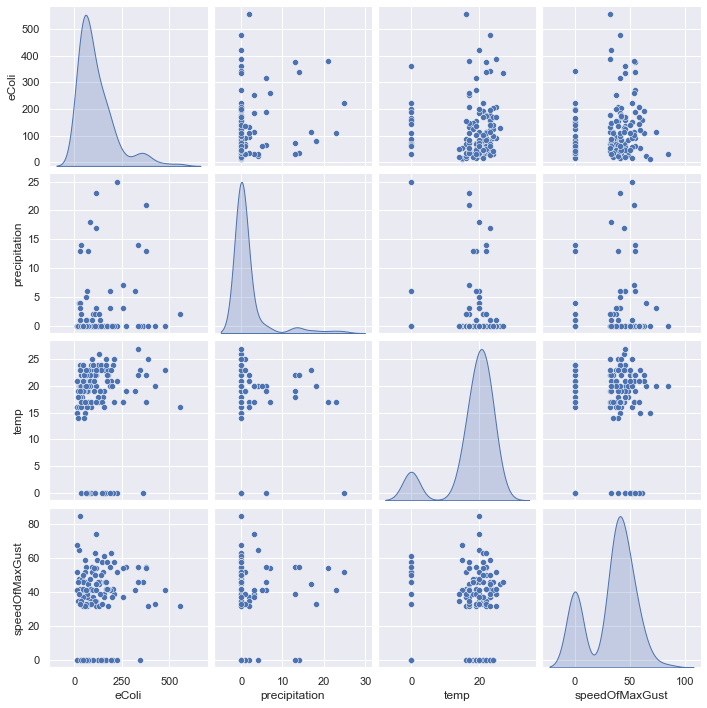

In [143]:
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

sns.pairplot(train_dataset[['eColi', 'precipitation', 'temp', 'speedOfMaxGust']], diag_kind='kde')


In [144]:


train_dataset.describe().transpose()

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('eColi')
test_labels = test_features.pop('eColi')

train_dataset.describe().transpose()[['mean', 'std']]


,mean,std
entryID,92.743421,55.181518
eColi,113.184211,98.437759
precipitation,1.552632,4.468861
temp,18.026316,6.907091
speedOfMaxGust,33.236842,21.018357


In [146]:
normalizer = tf.keras.layers.Normalization(axis=-1)

print(train_features.head())

normalizer.adapt(np.asarray(train_features).astype('float32'))


first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

     entryID  precipitation  temp  speedOfMaxGust
108      108            0.0  19.0            46.0
74        74            0.0  20.0            41.0
161      161            0.0  25.0            39.0
95        95            0.0  16.0            42.0
123      123            0.0  17.0            41.0
First example: [[108.   0.  19.  46.]]

Normalized: [[ 0.28 -0.35  0.14  0.61]]


In [160]:
ecoli = np.array(train_features['precipitation'])
# print(ecoli.head())
ecoli_normalizer = layers.Normalization(input_shape=[1,], axis=None)
ecoli_normalizer.adapt(ecoli)

ecoli_model = tf.keras.Sequential([
    ecoli_normalizer,
    layers.Dense(units=1)
])

ecoli_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

history = ecoli_model.fit(
    train_features['precipitation'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

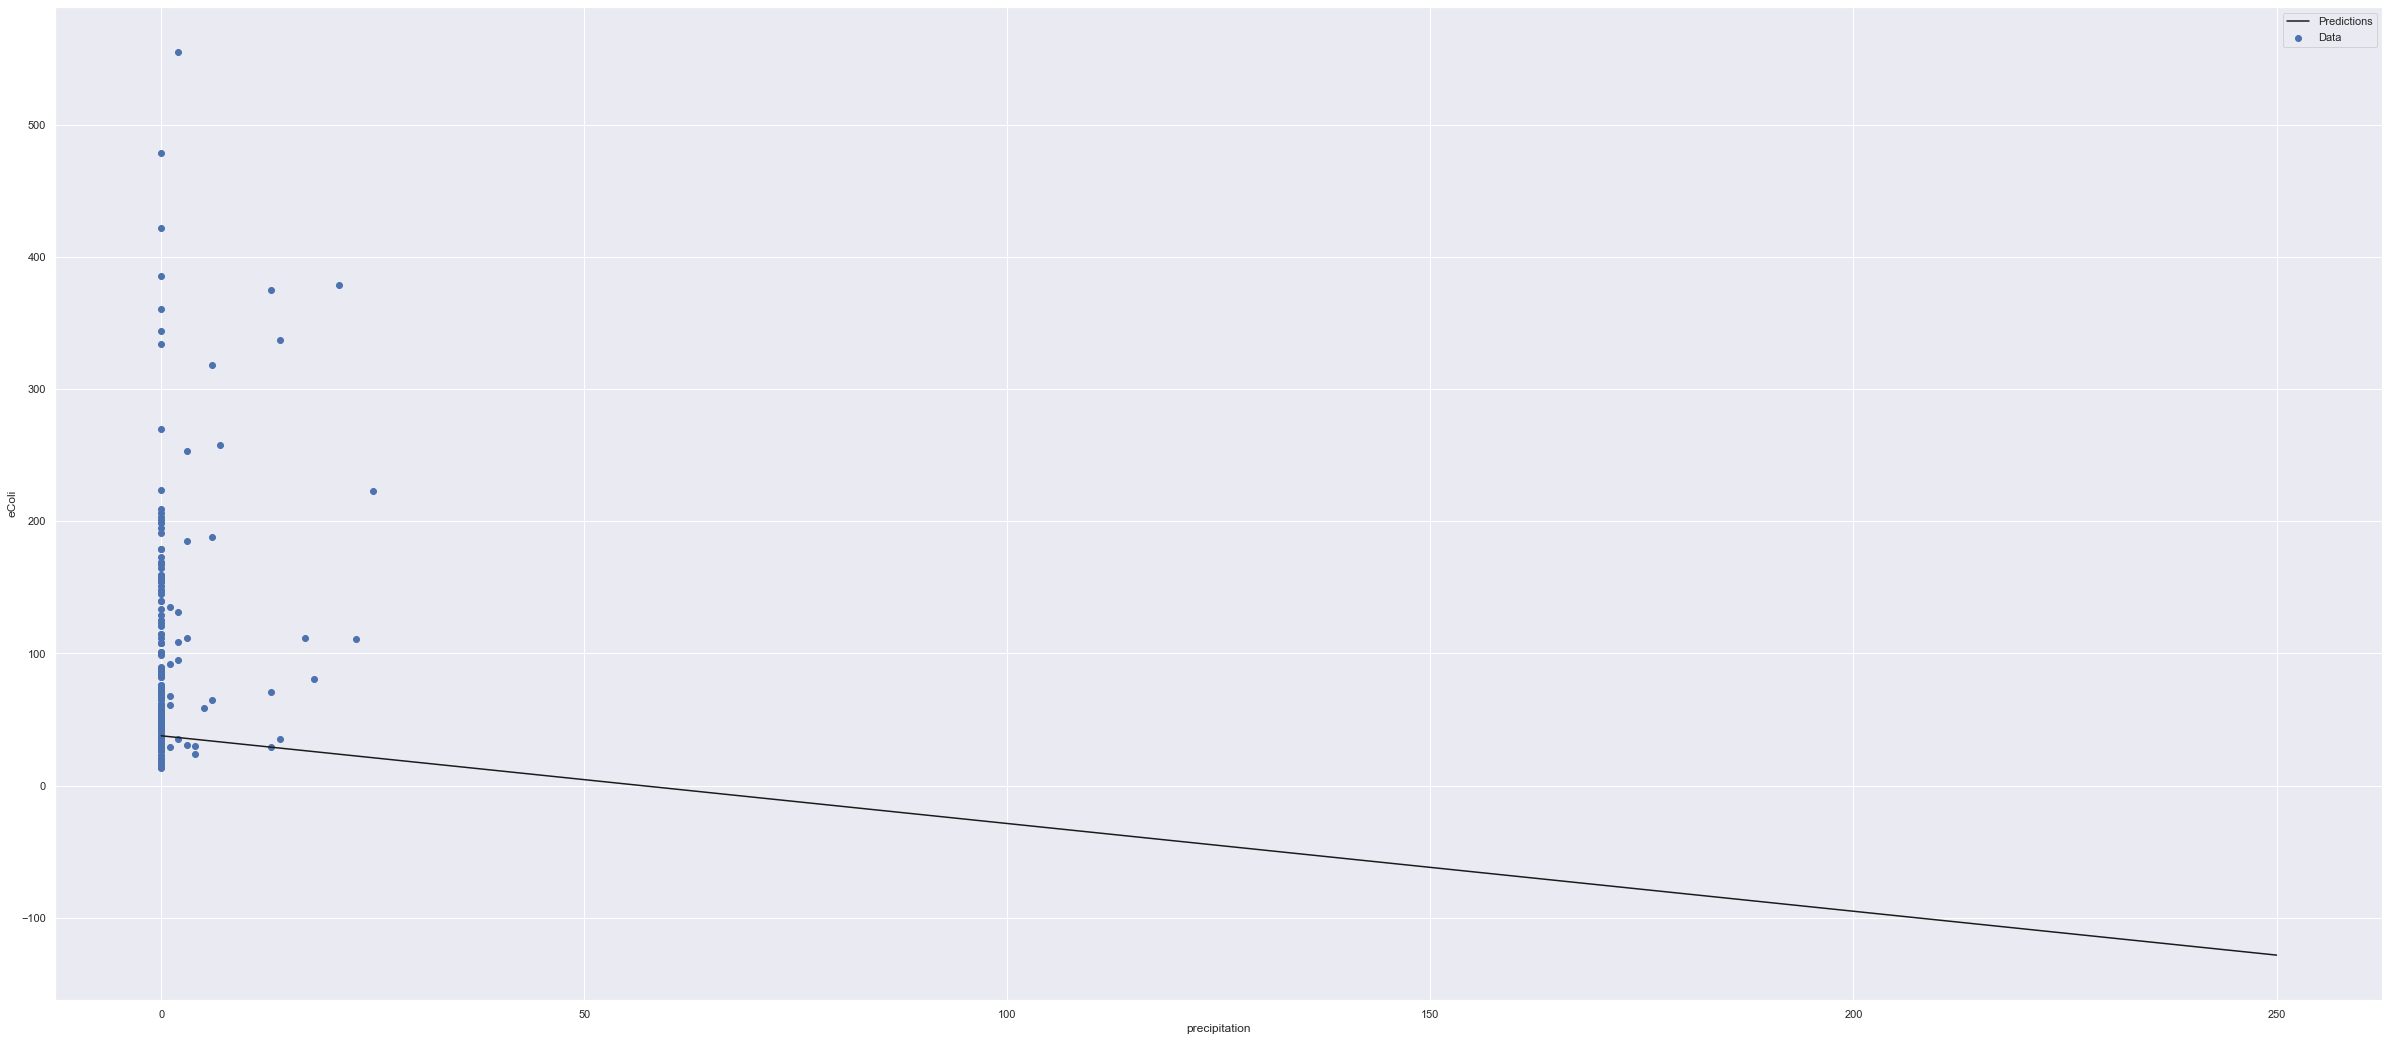

In [167]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

x = tf.linspace(0.0, 250, 251)
y = ecoli_model.predict(x)

def plot_horsepower(x, y):
  plt.scatter(train_features['precipitation'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('precipitation')
  plt.ylabel('eColi')
  plt.legend()

plot_horsepower(x, y)


  
